# 7.1 K-Means

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore")

In [2]:
pt = pd.read_csv('/Users/quanyinliu/Desktop/ADA/Project/train_proteins.csv')
pp = pd.read_csv('/Users/quanyinliu/Desktop/ADA/Project/train_peptides.csv')
cli = pd.read_csv('/Users/quanyinliu/Desktop/ADA/Project/train_clinical_data.csv')

In [3]:
cli_notna = cli[cli[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].notna().all(axis=1)]
print(len(cli), len(cli_notna))

2615 1562


In [4]:
cli_notna

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
5,55_18,55,18,7.0,13.0,38.0,0.0,On
6,55_24,55,24,16.0,9.0,49.0,0.0,On
7,55_30,55,30,14.0,13.0,49.0,0.0,On
...,...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.0,Off
2611,65043_54,65043,54,4.0,8.0,11.0,1.0,Off
2612,65043_60,65043,60,6.0,6.0,16.0,1.0,Off
2613,65043_72,65043,72,3.0,9.0,14.0,1.0,Off


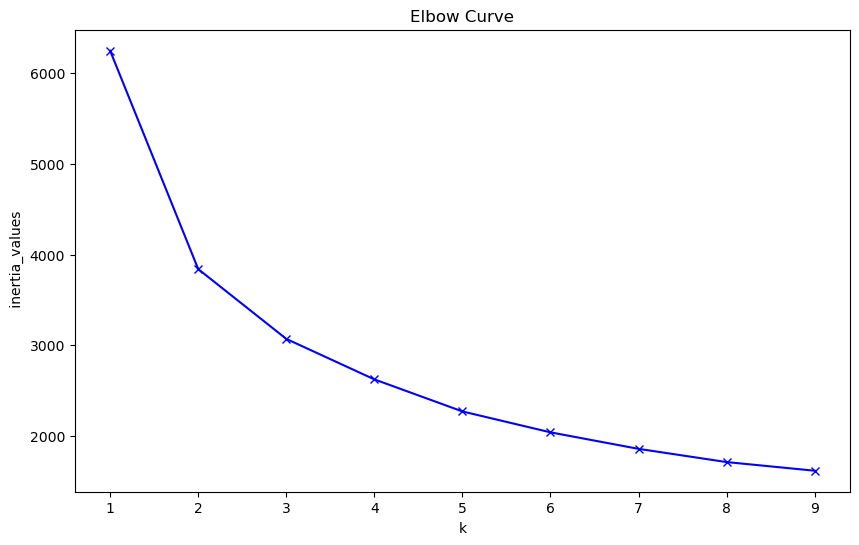

In [5]:
# To find the optimal number of clusters
X = cli_notna[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].values
inertia_values = []

scaler = StandardScaler()
data = scaler.fit_transform(X)

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, init='k-means++',random_state=0).fit(data)
    inertia_values.append(kmeans.inertia_)
    
plt.figure(figsize=(10,6))
plt.plot(range(1,10), inertia_values, 'bx-')
plt.xlabel('k')
plt.ylabel(' inertia_values')
plt.title('Elbow Curve')
plt.show()


In [6]:
# perform k-means++ model
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(data) 
print(y_kmeans)

[0 0 0 ... 2 2 2]


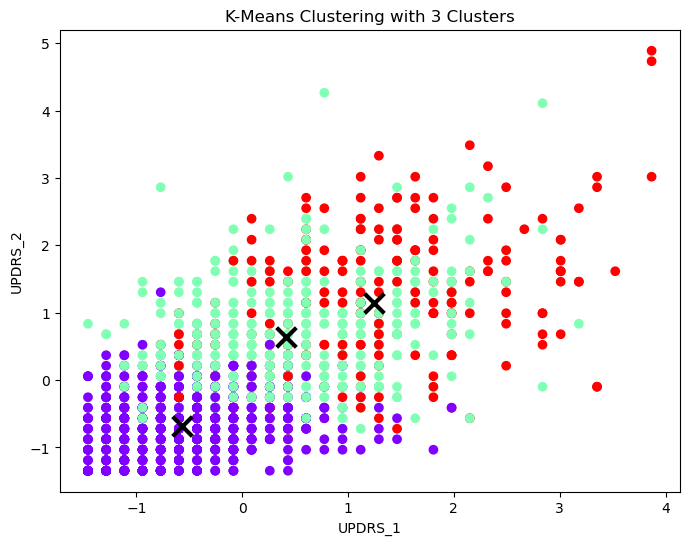

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,cluster
3,55_9,55,9,8.0,9.0,30.0,0.0,On,1
4,55_12,55,12,10.0,10.0,41.0,0.0,On,1
5,55_18,55,18,7.0,13.0,38.0,0.0,On,1
6,55_24,55,24,16.0,9.0,49.0,0.0,On,1
7,55_30,55,30,14.0,13.0,49.0,0.0,On,1


In [7]:
#visulize the cluster
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(data)
cli_notna['cluster'] = kmeans.labels_
# Plot the clusters
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(data[:,0], data[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color='black', marker='x', s=200, linewidths=3)
plt.title('K-Means Clustering with {} Clusters'.format(optimal_k))
plt.xlabel('UPDRS_1')
plt.ylabel('UPDRS_2')
plt.show()

cli_notna.head()

In [8]:
from sklearn.metrics import silhouette_score


silhouette_avg = silhouette_score(data, y_kmeans)

# Print the silhouette score
print('The silhouette score is:', silhouette_avg)

#The data is overlapping

The silhouette score is: 0.31015387020579904


In [9]:
unique_proteins = pp.groupby(['visit_id', 'visit_month', 'patient_id'])['UniProt'].unique().reset_index()
merged_df = cli_notna.merge(unique_proteins, on=['visit_id', 'visit_month', 'patient_id'])
merged_df.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,cluster,UniProt
0,55_12,55,12,10.0,10.0,41.0,0.0,On,1,"[O00391, O00533, O00584, O14498, O14773, O1479..."
1,55_36,55,36,17.0,18.0,51.0,0.0,On,1,"[O00391, O00533, O00584, O14498, O14773, O1479..."
2,942_12,942,12,5.0,2.0,25.0,0.0,NaN,0,"[O00391, O00533, O00584, O14498, O14773, O1479..."
3,942_48,942,48,2.0,6.0,35.0,0.0,NaN,0,"[O00391, O00533, O00584, O14498, O14773, O1479..."
4,1517_0,1517,0,11.0,6.0,25.0,5.0,On,1,"[O00391, O00533, O00584, O14773, O14791, O1524..."


In [10]:
# Convert lists of UniProt values to individual strings
merged_df['UniProt'] = merged_df['UniProt'].apply(lambda x: [str(val) for val in x])

# Create new dataframe with UniProt values as columns
uni_df = pd.DataFrame(merged_df['UniProt'].tolist())

# Add visit_id, visit_month, patient_id, and cluster columns to uni_df
uni_df[['visit_id', 'visit_month', 'patient_id', 'cluster']] = merged_df[['visit_id', 'visit_month', 'patient_id', 'cluster']]

# Fill in dataframe with 1's and 0's to indicate whether each UniProt value is present
uni_df = pd.get_dummies(uni_df, columns=uni_df.columns[:-4], prefix='', prefix_sep='').groupby(['visit_id', 'visit_month', 'patient_id', 'cluster']).max().reset_index()
uni_df.head()

,visit_id,visit_month,patient_id,cluster,O00391,O00533,O15240,O00533,O00584,O14498,...,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7,Q9UNU6,Q9Y646,Q9Y6R7,Q9Y646,Q9Y6R7,Q9Y6R7
0,10053_0,0,10053,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10053_12,12,10053,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10053_18,18,10053,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10138_12,12,10138,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10138_24,24,10138,2,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
for index, row in pt.iterrows():
    visit_id, visit_month, patient_id, UniProt, NPX = row['visit_id'], row['visit_month'], row['patient_id'], row['UniProt'], row['NPX']
    uni_df.loc[(uni_df['visit_id'] == visit_id) & (uni_df['visit_month'] == visit_month) & (uni_df['patient_id'] == patient_id), UniProt] = NPX
uni_df.head()

,visit_id,visit_month,patient_id,cluster,O00391,O00533,O15240,O00533,O00584,O14498,...,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7,Q9UNU6,Q9Y646,Q9Y6R7,Q9Y646,Q9Y6R7,Q9Y6R7
0,10053_0,0,10053,0,9104.27,402321.0,83002.9,402321.0,0.00,0.0,...,65900.0,15382.0,0.00,19017.40,15382.0,0.00,19017.40,0.00,19017.40,19017.40
1,10053_12,12,10053,0,10464.20,435586.0,197117.0,435586.0,0.00,0.0,...,65668.1,0.0,9295.65,25697.80,0.0,9295.65,25697.80,9295.65,25697.80,25697.80
2,10053_18,18,10053,0,13235.70,507386.0,126506.0,507386.0,7126.96,24525.7,...,59986.1,10813.3,0.00,29102.70,10813.3,0.00,29102.70,0.00,29102.70,29102.70
3,10138_12,12,10138,0,12600.20,494581.0,156313.0,494581.0,9165.06,27193.5,...,106564.0,26077.7,21441.80,7642.42,26077.7,21441.80,7642.42,21441.80,7642.42,7642.42
4,10138_24,24,10138,2,12003.20,522138.0,151169.0,522138.0,4498.51,17189.8,...,59471.4,12639.2,15091.40,6168.55,12639.2,15091.40,6168.55,15091.40,6168.55,6168.55


In [12]:
from sklearn.linear_model import LogisticRegression

train_data = uni_df.sample(frac=0.8, random_state=1)
test_data = uni_df.drop(train_data.index)

model = LogisticRegression()
model.fit(train_data.drop(['visit_id', 'visit_month', 'patient_id', 'cluster'], axis=1), train_data['cluster'])

test_data['predicted_cluster'] = model.predict(test_data.drop(['visit_id', 'visit_month', 'patient_id', 'cluster'], axis=1))

accuracy = (test_data['predicted_cluster'] == test_data['cluster']).mean()
print('Accuracy:', accuracy)

Accuracy: 0.584070796460177


In [29]:
uni_df.to_csv('my_dataframe.csv', index=False)

In [30]:
uni_df = pd.read_csv('/Users/quanyinliu/Desktop/ADA/Project/uni_df.csv')

In [31]:
uni_df2 = uni_df.merge(merged_df[['visit_id', 'visit_month', 'patient_id', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']], on=['visit_id', 'visit_month', 'patient_id'], how='left')

In [32]:
uni_df2 

,visit_id,visit_month,patient_id,cluster,O00391,O00533,O15240,O00533.1,O00584,O14498,...,Q9UNU6.47,Q9Y646.48,Q9Y6R7.54,Q9Y646.49,Q9Y6R7.55,Q9Y6R7.56,updrs_1,updrs_2,updrs_3,updrs_4
0,10053_0,0,10053,3,9104.27,402321.0,83002.9,402321.0,0.00,0.0,...,15382.0,0.00,19017.40,0.00,19017.40,19017.40,3.0,0.0,13.0,0.0
1,10053_12,12,10053,3,10464.20,435586.0,197117.0,435586.0,0.00,0.0,...,0.0,9295.65,25697.80,9295.65,25697.80,25697.80,4.0,2.0,8.0,0.0
2,10053_18,18,10053,3,13235.70,507386.0,126506.0,507386.0,7126.96,24525.7,...,10813.3,0.00,29102.70,0.00,29102.70,29102.70,2.0,2.0,0.0,0.0
3,10138_12,12,10138,2,12600.20,494581.0,156313.0,494581.0,9165.06,27193.5,...,26077.7,21441.80,7642.42,21441.80,7642.42,7642.42,3.0,6.0,31.0,0.0
4,10138_24,24,10138,1,12003.20,522138.0,151169.0,522138.0,4498.51,17189.8,...,12639.2,15091.40,6168.55,15091.40,6168.55,6168.55,4.0,7.0,19.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,8699_0,0,8699,1,7361.28,484747.0,121582.0,484747.0,21651.70,0.0,...,14763.7,27225.50,5919.37,27225.50,5919.37,5919.37,17.0,13.0,11.0,4.0
560,8699_12,12,8699,1,8194.96,258441.0,38205.6,258441.0,15176.50,0.0,...,11964.1,13411.60,7937.01,13411.60,7937.01,7937.01,13.0,15.0,12.0,0.0
561,8699_24,24,8699,1,9983.00,400290.0,77493.6,400290.0,24240.10,0.0,...,14413.9,28225.50,8062.07,28225.50,8062.07,8062.07,11.0,10.0,13.0,2.0
562,942_12,12,942,1,6757.32,360858.0,86847.4,360858.0,18367.60,14760.7,...,19183.7,17804.10,12277.00,17804.10,12277.00,12277.00,5.0,2.0,25.0,0.0


In [33]:
from sklearn.linear_model import LogisticRegression

def predict(key):
    train_data = uni_df2.sample(frac=0.8, random_state=1)
    test_data = uni_df2.drop(train_data.index)


    model = LogisticRegression()
    droplist = ['visit_id', 'visit_month', 'patient_id', 'cluster','updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
    model.fit(train_data.drop(droplist, axis=1), train_data[key])

    test_data['predicted_'+key] = model.predict(test_data.drop(droplist, axis=1))


    accuracy = (test_data['predicted_'+key] == test_data[key]).mean()
    return accuracy
  
p1, p2, p3, p4 = predict('updrs_1'), predict('updrs_2'), predict('updrs_3'), predict('updrs_4')
print(p1, p2, p3, p4, (p1 + p2 + p3 + p4) / 4)

0.13274336283185842 0.08849557522123894 0.07079646017699115 0.6460176991150443 0.2345132743362832


-